## MAI ML Contest | Time Series
Цирулев Николай Владимирович М8О-308Б-22


In [39]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

## Data loading

In [40]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   int64  
 1   Date          6255 non-null   object 
 2   Weekly_Sales  6255 non-null   float64
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   CPI           6255 non-null   float64
 6   Unemployment  6255 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 342.2+ KB


,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-01-10,1453329.50,71.89,2.603,211.671989,7.838
1,1,2010-02-04,1594968.28,62.27,2.719,210.820450,7.808
2,1,2010-02-07,1492418.14,80.91,2.669,211.223533,7.787
3,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106
4,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106


## Data analysis

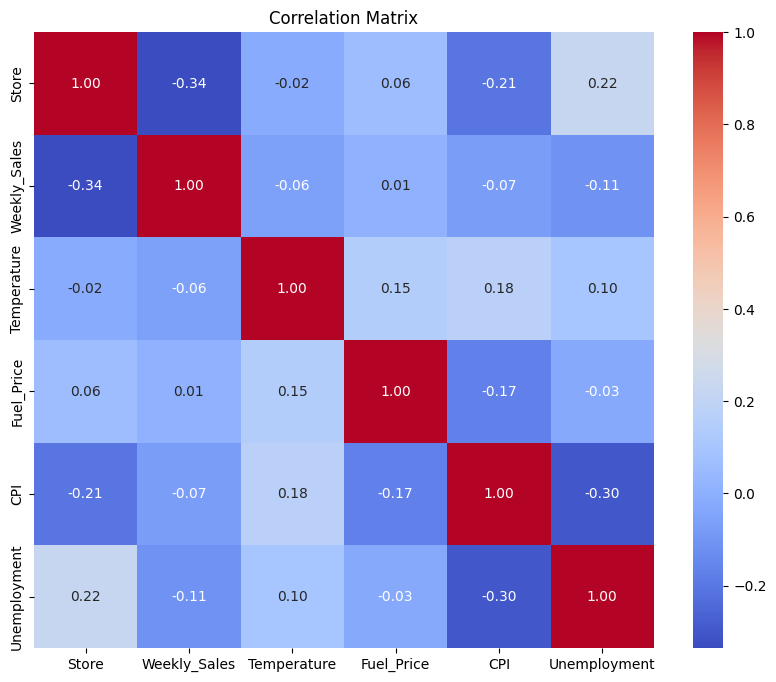

In [41]:
plt.figure(figsize=(10, 8))
t = train.drop(['Date'], axis=1)
sns.heatmap(t.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Data preparation and purification

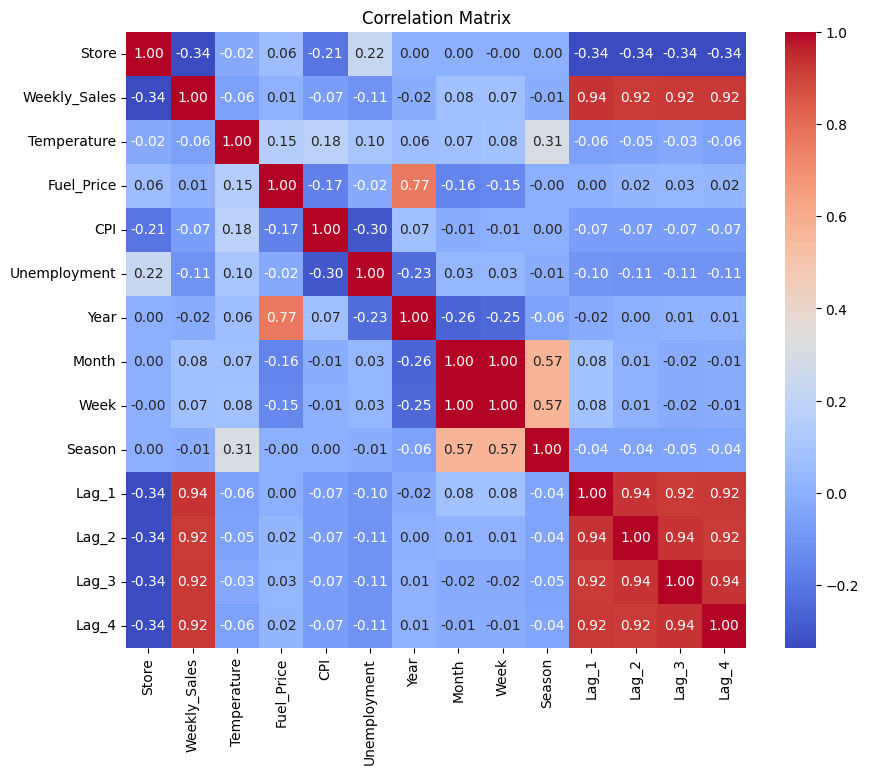

In [42]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

for df in [train, test]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Season'] = df['Month'] % 12 // 3 + 1

for lag in range(1, 5):
    train[f'Lag_{lag}'] = train.groupby('Store')['Weekly_Sales'].shift(lag)

train.dropna(inplace=True)

plt.figure(figsize=(10, 8))
t = train.drop(['Date'], axis=1)
sns.heatmap(t.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Model training and testing block

In [43]:
X = train.drop(['Weekly_Sales', 'Date'], axis=1)
y = train['Weekly_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = Ridge(alpha=1.0, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_val_scaled)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f'MAPE: {mape:.5f}')

last_sales = {}
for store, group in train.groupby('Store'):
    last_values = group['Weekly_Sales'].tail(4).values
    last_sales[store] = list(last_values) if len(last_values) == 4 else [0] * (4 - len(last_values)) + list(last_values)

for lag in range(1, 5):
    test[f'Lag_{lag}'] = test['Store'].map(lambda store: last_sales.get(store, [0]*4)[lag-1])

test.fillna(0, inplace=True)

X_test = test.drop(['Date'], axis=1)
X_test_scaled = scaler.transform(X_test)

y_predict = model.predict(X_test_scaled)

MAPE: 0.09230


## Submit

In [44]:
data = {
    "source_attractiveness": y_predict
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")